## Assigment: Neural network basics

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

For this task I intentionally provide no boilerplate code, because very puprpose of this task is getting you comforatable with basic code template for desiging NNs in pytorch. I higly recommend you to revisit all the last seminar materials.

#### Task

* Implement simple **fully-convolutional** neural architecture for classification. Make sure it is small enought to run on your home machine.
* Provide dataset visulization.
* Provide train/test split and validation

#### Requirements

* Architecture should derive from `torch.nn.Module`
* Use `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. But if you manage co simplify this step using dataset `torchivision`, I will only encourage you.
* Implement at least one data transformer, but make sure it is useful for classification task.
* Use FashionMNIST dataset https://github.com/zalandoresearch/fashion-mnist
* Make sure you can fix random seed for all components of your code to make experiments reproducible
* Since you architecure should be fully-convolutional, make sure it does not depend on input size.

In [1]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import random
import os.path
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)
    
torch.backends.cudnn.deterministic=True  

In [3]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

In [4]:
train_set = datasets.FashionMNIST(root=root, train=True, transform=transforms.ToTensor(), download=True)

pixel_sum = torch.zeros(1)
pixel_num = 0
for image, _ in train_set:
    pixel_sum += image.sum()
    pixel_num += image.numel()
mean = pixel_sum / pixel_num

dev_from_mean = torch.zeros(1)
for image, _ in train_set:
    dev_from_mean += ((image - mean)**2).sum()
std = torch.sqrt(dev_from_mean / pixel_num)

print('Mean is =', mean.item())
print('Std is =', std.item())

Mean is = 0.2860410809516907
Std is = 0.3530243933200836


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean.item()], std=[std.item()])
])
    
train_set = datasets.FashionMNIST(root=root, train=True, transform=transform, download=True)
test_set = datasets.FashionMNIST(root=root, train=False, transform=transform, download=True)

print('train_set size is', train_set.__len__())
print('test_set size is', test_set.__len__())

train_set size is 60000
test_set size is 10000


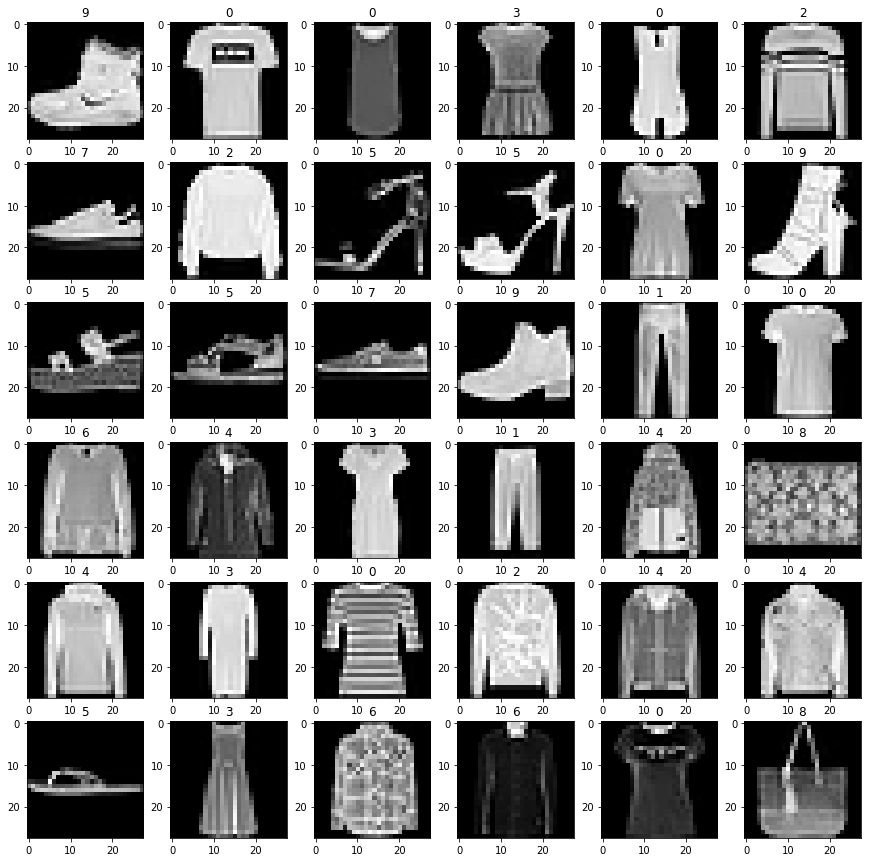

In [6]:
fig=plt.figure(figsize=(15, 15))

rows = 6
columns = 6
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(train_set.train_data[i].numpy(), cmap='gray')
    plt.title('%i' % train_set.train_labels[i])

plt.show()

In [7]:
def __init_fn(worker_id):
    np.random.seed(worker_id)  

batch_size = 100

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=__init_fn)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=__init_fn)

In [8]:
class Flatten(nn.Module):
    # Flattens the dimensions into one for each input tensor row.
    
    def __init__(self):
        super(Flatten, self).__init__()
   
    def forward(self, x):
        return x.view(x.size(0), -1)


class Model(nn.Module):
    # Classification model
    
    def __init__(self):
        super(Model, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            Flatten(),
            nn.Dropout(p=0.25),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        return self.seq(x)

In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
model = Model()

In [11]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    
    for images, labels in train_dataloader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    
    correct = 0
    for images, labels in test_dataloader:
        outputs = model(images)
                
        _, predicted_labels = torch.max(outputs.data, dim=1)
        correct += (predicted_labels == labels).sum()

    accuracy = 100.0 * correct.item() / len(test_set)
            
    print('After epoch', epoch)
    print('Loss =', loss.data.item())
    print('Accuracy =', accuracy)
    print()

After epoch 0
Loss = 0.6115177273750305
Accuracy = 85.54

After epoch 1
Loss = 0.2841572165489197
Accuracy = 87.45

After epoch 2
Loss = 0.41525137424468994
Accuracy = 88.45

After epoch 3
Loss = 0.18852485716342926
Accuracy = 88.95

After epoch 4
Loss = 0.21006172895431519
Accuracy = 89.23

